In [10]:
from src.textclf_transformer import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import numpy as np
import matplotlib.pyplot as plt

In [11]:
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())


2.5.1+cu121
12.1
True


In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dtype = torch.float16 if device == 'cuda' else torch.float32
print(f"Używane urządzenie: {device}, dtype: {dtype}")

Używane urządzenie: cuda, dtype: torch.float16


In [13]:
import torch

print("flash_sdp_enabled:", torch.backends.cuda.flash_sdp_enabled())
print("mem_efficient_sdp_enabled:", torch.backends.cuda.mem_efficient_sdp_enabled())
print("math_sdp_enabled:", torch.backends.cuda.math_sdp_enabled())


flash_sdp_enabled: True
mem_efficient_sdp_enabled: True
math_sdp_enabled: True


Testowanie N = 128...
  FAVOR+                        : 6.3549 ms
GPU cache has been emptied.
  LSH                           : 9.2271 ms
GPU cache has been emptied.
  SDPA (nn.MultiheadAttention)  : 1.0318 ms
GPU cache has been emptied.
  SDPA (Ours + native sdpa)     : 1.1996 ms
GPU cache has been emptied.
  SDPA (Ours)                   : 1.6524 ms
GPU cache has been emptied.
Testowanie N = 256...
  FAVOR+                        : 7.4040 ms
GPU cache has been emptied.
  LSH                           : 9.5137 ms
GPU cache has been emptied.
  SDPA (nn.MultiheadAttention)  : 1.0109 ms
GPU cache has been emptied.
  SDPA (Ours + native sdpa)     : 1.0655 ms
GPU cache has been emptied.
  SDPA (Ours)                   : 1.6614 ms
GPU cache has been emptied.
Testowanie N = 512...
  FAVOR+                        : 5.5782 ms
GPU cache has been emptied.
  LSH                           : 9.9205 ms
GPU cache has been emptied.
  SDPA (nn.MultiheadAttention)  : 1.1751 ms
GPU cache has been emptied

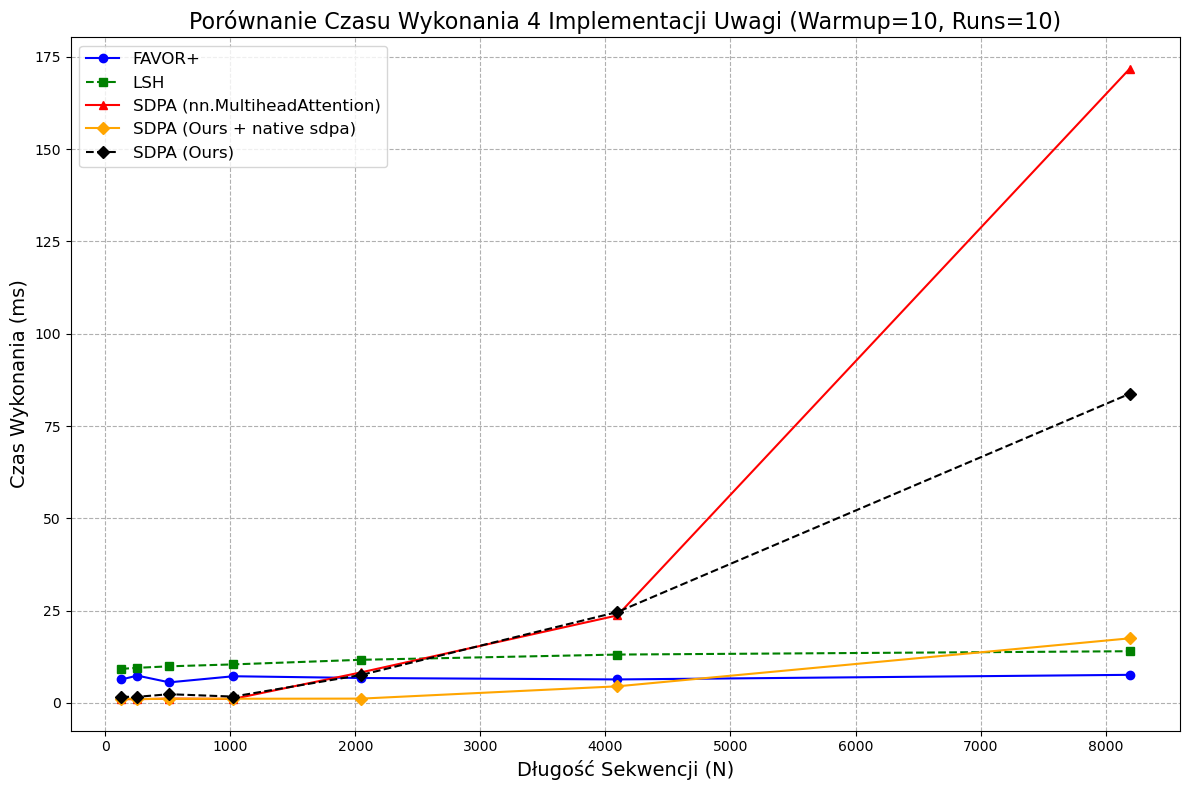

In [14]:
from matplotlib import pyplot as plt
# Ustawienia Globalne
EMBED_DIM = 128
ATTN_EMBED_DIM = 128
NUM_HEADS = 8
BATCH_SIZE = 1
NUM_WARMUP = 10
NUM_RUNS = 10
HEAD_DIM = EMBED_DIM // NUM_HEADS


favor = AttentionBlock(
    embedding_dim=EMBED_DIM, num_heads=NUM_HEADS, projection_bias=True,
    attn_dropout=0.0, out_dropout=0.0, attention_kind='favor',
    attention_params={'nb_features': 64, 'redraw_interval': 0, 'ortho_features': True, 'phi': 'exp', 'stabilize': True, 'eps': 1.0e-6}
).to(device).to(dtype).eval()

lsh = AttentionBlock(
    embedding_dim=EMBED_DIM, num_heads=NUM_HEADS, projection_bias=True,
    attn_dropout=0.0, out_dropout=0.0, attention_kind='lsh',
    attention_params={'num_hashes': 2, 'chunk_size': 64, 'mask_within_chunks': True}
).to(device).to(dtype).eval()

mha_torch = nn.MultiheadAttention(embed_dim=EMBED_DIM, num_heads=NUM_HEADS, dropout=0.0,
                            bias=True, batch_first=True, device=device).to(dtype).eval()

mha_ours_native_sdpa = AttentionBlock(
    embedding_dim=EMBED_DIM,  num_heads=NUM_HEADS, projection_bias=True,
    attn_dropout=0.0, out_dropout=0.0, attention_kind='mha',
    attention_params={'use_native_sdpa': True}
).to(device).to(dtype).eval()

mha_ours = AttentionBlock(
    embedding_dim=EMBED_DIM,  num_heads=NUM_HEADS, projection_bias=True,
    attn_dropout=0.0, out_dropout=0.0, attention_kind='mha',
    attention_params={'use_native_sdpa': False}
).to(device).to(dtype).eval()


# ==============================================================================
# 2. FUNKCJE POMOCNICZE
# ==============================================================================
def rand_inputs(seq_len, device, dtype):
    x = torch.randn(BATCH_SIZE, seq_len, EMBED_DIM, device=device, dtype=dtype)
    mask = torch.rand(BATCH_SIZE, seq_len, device=device) < 0.1
    return x, mask


def time_run(func, x, key_padding_mask, num_runs, num_warmup):
    """Przeprowadza rozgrzewkę i mierzy czas uśredniony (ms)."""
    if device == 'cuda':
        torch.cuda.synchronize()
        torch.cuda.empty_cache()

    # WARMUP
    for _ in range(num_warmup):
        _ = func(x, key_padding_mask)
    if device == 'cuda':
        torch.cuda.synchronize()

    # POMIAR
    if device == 'cuda':
        start_event = torch.cuda.Event(enable_timing=True)
        end_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        for _ in range(num_runs):
            _ = func(x, key_padding_mask)
        end_event.record()
        torch.cuda.synchronize()
        total_time_ms = start_event.elapsed_time(end_event)
    else:
        start_time = time.time()
        for _ in range(num_runs):
            _ = func(x, key_padding_mask)
        total_time_ms = (time.time() - start_time) * 1000
        print(total_time_ms)

    

    return total_time_ms / num_runs



SEQ_LEN_LIST = [128, 256, 512, 1024, 2048, 4096, 8192]

results = {
    "FAVOR+": [],
    "LSH": [],
    "SDPA (nn.MultiheadAttention)": [],
    "SDPA (Ours + native sdpa)": [],
    "SDPA (Ours)": [],
}

implementations = {
    "FAVOR+": lambda x, kpm: favor(x, key_padding_mask=kpm),
    "LSH": lambda x, kpm: lsh(x, key_padding_mask=kpm),
    "SDPA (nn.MultiheadAttention)": lambda x, kpm: mha_torch(x, x, x, need_weights=False, key_padding_mask=kpm),
    "SDPA (Ours + native sdpa)": lambda x, kpm: mha_ours_native_sdpa(x, key_padding_mask=kpm),
    "SDPA (Ours)": lambda x, kpm: mha_ours(x, key_padding_mask=kpm),
}


with torch.no_grad():
    for seq_len in SEQ_LEN_LIST:
        print(f"Testowanie N = {seq_len}...")

        x, kpm = rand_inputs(seq_len, device=device, dtype=dtype)

        for name, func in implementations.items():

            avg_time = time_run(func, x, kpm, NUM_RUNS, NUM_WARMUP)

            results[name].append(avg_time)
            print(f"  {name:<30}: {avg_time:.4f} ms")


            if torch.cuda.is_available():
                torch.cuda.empty_cache()

print("\n--- Zakończono pomiary ---")

plt.figure(figsize=(12, 8))

for name, times in results.items():
    valid_times = [times[i] for i, x in enumerate(times) if not np.isnan(x)]
    valid_seq_lens = [SEQ_LEN_LIST[i] for i, x in enumerate(times) if not np.isnan(x)]

    # Dodanie stylów dla lepszej czytelności
    if "FAVOR" in name:
        style = {'color': 'blue', 'linestyle': '-', 'marker': 'o'}
    elif "LSH" in name:
        style = {'color': 'green', 'linestyle': '--', 'marker': 's'}
    elif "MultiheadAttention" in name:
        style = {'color': 'red', 'linestyle': '-', 'marker': '^'}
    elif "native" in name:
        style = {'color': 'orange', 'linestyle': '-', 'marker': 'D'}
    elif "Ours" in name:
        style = {'color': 'black', 'linestyle': '--', 'marker': 'D'}

    plt.plot(valid_seq_lens, valid_times, **style, label=name)


plt.title(f'Porównanie Czasu Wykonania 4 Implementacji Uwagi (Warmup={NUM_WARMUP}, Runs={NUM_RUNS})', fontsize=16)
plt.xlabel('Długość Sekwencji (N)', fontsize=14)
plt.ylabel(f'Czas Wykonania (ms)', fontsize=14)
plt.grid(True, which="both", ls="--")
plt.legend(fontsize=12, loc='upper left')
plt.tight_layout()
plt.show()